In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/dataset.csv")

In [3]:
df.sample(10)

,app_id,app_name,review_text,review_score,review_votes
3917,440,Team Fortress 2,♥♥♥♥ for new players,1,0
12690,296550,Niko: Through The Dream,Niko is a very visually pleasent puzzle advent...,1,1
11248,409710,BioShock Remastered,Ever since I installed this poorly optomized P...,-1,0
1003,9930,NaN,'You are driving in the wrong direction! Turn ...,-1,0
2093,200510,XCOM: Enemy Unknown,"Just superb, turn based strategy at its best.....",1,0
7747,233470,Evoland,Not as short a game as everyone is claiming it...,1,0
19937,262060,Darkest Dungeon®,Early Access Review,1,0
6803,241620,Inquisitor,I have a phrase: It's called 'Diablo Clone'. ...,-1,0
11089,238460,BattleBlock Theater,"this game is so epic, the levels are never bor...",1,0
2265,252490,Rust,Early Access Review,-1,0


In [4]:
df.shape

(20000, 5)

In [5]:
df.isnull().sum()

app_id            0
app_name        582
review_text      20
review_score      0
review_votes      0
dtype: int64

In [6]:
df = df.dropna(subset=['review_text'])

In [7]:
df.duplicated(subset=['review_text']).sum()

3366

In [8]:
df = df.drop_duplicates(subset=['review_text'])

In [9]:
df.shape

(16614, 5)

In [10]:
df.sample(10)

,app_id,app_name,review_text,review_score,review_votes
15134,418300,Wick,"Picture this: a haunted, gated patch of forest...",1,1
10234,255710,Cities: Skylines,Gameplay: A- Plot: n/a Graphics/Art Style: A- ...,1,0
2547,221380,Age of Empires II (2013),This game is pretty fun! It can get abit compe...,1,0
19808,322170,Geometry Dash,I ended up getting this game on my iPhone so I...,1,0
14841,219640,Chivalry: Medieval Warfare,Very fun stuff!,1,0
6861,304050,Trove,-Remake of Cube World -Not dropped off the sid...,1,0
19189,211420,DARK SOULS™: Prepare To Die Edition,Fun and relaxing game.,1,1
14767,43110,NaN,"There are Russians, Vodka, weapons, monsters, ...",1,0
6640,46500,Syberia,"Really great game. Excellent story/plot, great...",1,0
1002,265930,Goat Simulator,This game is way too goat for me. I simply can...,-1,0


In [11]:
value_counts = df['review_score'].value_counts()
value_counts

review_score
 1    13719
-1     2895
Name: count, dtype: int64

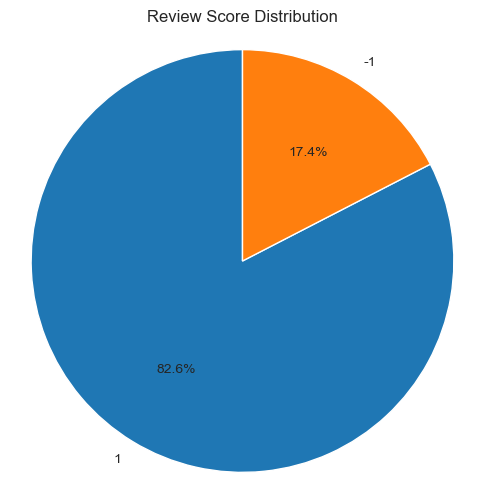

In [12]:
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Review Score Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is a circle.
plt.show()

In [13]:
from utils.x_flow import BasePipeline, PipeLambda
from utils.x_flow.pandas import PandasPipeline, ReadFile, WriteFile

In [30]:
class DataCleaner(PandasPipeline):
    def __init__(self, get_url=True, drop_copies=True, drop_null=True, drop_empty_reviews=True, include_raw_text=True):
        super().__init__()
        self.get_url = get_url
        self.drop_copies = drop_copies
        self.drop_null = drop_null
        self.drop_empty_reviews = drop_empty_reviews
        self.include_raw_text = include_raw_text

    def process_df(self, df: pd.DataFrame) -> pd.DataFrame:
        required_columns = ['app_id', 'app_name', 'review_text', 'review_score']
        self.validate_df(df, required_cols=required_columns)
        df = df[required_columns]

        if self.drop_copies:
            df = df.drop_duplicates()
        if self.drop_null:
            df = df.dropna(subset=['review_text'])
        else:
            df = df.fillna(value="<MISSING>")

        target_values = set(df['review_score'].unique())
        if len(target_values) > 2:
            raise KeyError(f"column review_score should contain either [1, 0] or [-1, 1]. got {target_values}")
        if target_values.issubset({-1, 1}):
            df['review_score'] = df['review_score'].apply(lambda x: 0 if x == -1 else x)
        elif target_values.issubset({0, 1}):
            pass
        else:
            raise KeyError(f"column review_score should contain either [1, 0] or [-1, 1]. got {target_values}")

        if self.get_url:
            df['urls'] = df['review_text'].apply(self.extract_url)
            df['contains_url'] = df['urls'].apply(lambda x: len(x) > 0)

        if self.include_raw_text:
            df['raw_text'] = df['review_text']
        df['review_text'] = df['review_text'].apply(self.remove_url)
        df['review_text'] = df['review_text'].apply(self.basic_preprocess)
        df['review_length'] = df['review_text'].apply(len)
        df['word_counts'] = df['review_text'].apply(lambda x: len(x.split()))
        if self.drop_empty_reviews:
            df = df[df['word_counts'] > 0]
        return df

    def process_one_chunk(self, chunk: pd.DataFrame) -> pd.DataFrame:
        return self.process_df(chunk)

    @staticmethod
    def basic_preprocess(string):
        # Remove single dots that are not part of numbers (optional, uncomment if needed)
        # string = re.sub(r"\.(?!\d)", "", string)

        # Retain specific characters and convert to lowercase
        string = re.sub(r"[^a-zA-Z\s\u263a-\U0001F9FF0-9/\.,:)=()]", "", string.lower())

        # Remove patterns of multiple consecutive repetitive characters (e.g., ::::::::: or =================)
        string = re.sub(r'([:!.,;?])\1+', ' ', string)  # Matches repeated sequences of specific characters (e.g., '::::' or '====')

        # Remove patterns with excessive whitespace
        string = re.sub(r'\s+', ' ', string)  # Replace multiple spaces with a single space

        # Strip leading/trailing spaces
        string = string.strip()

        return string

    @staticmethod
    def extract_url(string):
        regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        url = re.findall(regex, string)
        return [x[0] for x in url]

    @staticmethod
    def remove_url(string):
        regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        return re.sub(regex, "", string).strip()

In [15]:
df

,app_id,app_name,review_text,review_score,review_votes
0,252490,Rust,Early Access Review,1,0
1,107410,Arma 3,? why won't this download,1,0
2,459010,Ghost Town Mine Ride & Shootin' Gallery,Really fantastic game experience - a combinati...,1,0
5,8930,Sid Meier's Civilization V,"Go out on an adventure, be honerouble, get res...",1,0
6,108710,Alan Wake,The best written game I have ever played as we...,1,0
...,...,...,...,...,...
19991,255710,Cities: Skylines,some times this game will ♥♥♥♥ YOU OVER REALY ...,1,0
19994,250110,Assault Android Cactus,Really solid twin stick shooter with tight con...,1,0
19995,205950,Jet Set Radio,Super brother,1,0
19996,377160,Fallout 4,Friggin awesome but not quite as good as FNV.....,1,0


In [36]:
dc_pipeline = ReadFile(chunksize = 100) >>\
              DataCleaner() >>\
              PipeLambda(lambda x: x.drop_duplicates(subset=['review_text']), "DropDuplicates") \
              >>\
              WriteFile(save_path="data/preprocessed/cleaned.csv", index = False)

In [37]:
path = dc_pipeline.step("data/dataset.csv")

1.Running FileLoader(in_chunks):
Successfully read file: data/dataset.csv
2.Running DataCleaner:


DataCleaner: Processing chunks: 200it [00:03, 55.96it/s]


All chunks processed successfully!
3.Running DropDuplicates:
4.Running FileSaver:
Successfully written the file to data/preprocessed/cleaned.csv


In [38]:
clean_df = pd.read_csv(path)

In [39]:
clean_df['review_text']

0                                      early access review
1                                   why wont this download
2        really fantastic game experience a combination...
3        go out on an adventure, be honerouble, get res...
4        the best written game i have ever played as we...
                               ...                        
16484    some times this game will ♥♥♥♥ you over realy ...
16485    really solid twin stick shooter with tight con...
16486                                        super brother
16487    friggin awesome but not quite as good as fnv yet.
16488    this game is really awesome. though the story ...
Name: review_text, Length: 16489, dtype: object

In [41]:
clean_df[clean_df['review_text'].apply(lambda x: len(x.split()))==1]

,app_id,app_name,review_text,review_score,urls,contains_url,raw_text,review_length,word_counts
149,570,Dota 2,cool,1,[],False,cool,4,1
175,39210,FINAL FANTASY XIV Online,.,0,[],False,.,1,1
225,443580,Antenna,neat,1,[],False,Neat,4,1
275,351800,Dev Guy,:))),1,[],False,:))),4,1
304,255710,Cities: Skylines,quality1,1,[],False,Quality1,8,1
...,...,...,...,...,...,...,...,...,...
15725,311210,Call of Duty: Black Ops III,bored.,0,[],False,bored.,6,1
15870,257850,Hyper Light Drifter,incredible,1,[],False,-incredible,10,1
15906,251990,Long Live The Queen,ohmygoshijustwantedtobebrionysdistantloverands...,1,[],False,Ohmygoshijustwantedtobebriony'sdistantloverand...,481,1
16013,513000,Kuboom,cancer,0,[],False,Cancer,6,1


In [47]:
from wordcloud import WordCloud

In [48]:
neg_corpus = " ".join(clean_df[clean_df['review_score'] == 0]['review_text'])
pos_corpus = " ".join(clean_df[clean_df['review_score'] == 1]['review_text'])

In [49]:
neg_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neg_corpus)
pos_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(pos_corpus)

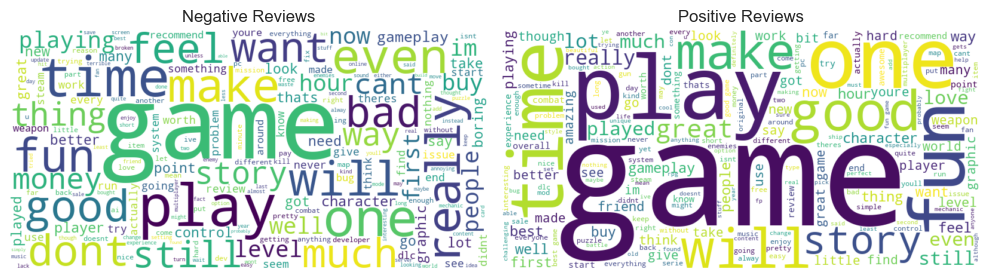

In [50]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

# Plot positive word cloud
plt.subplot(1, 2, 2)
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

# Show the plot
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Parag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


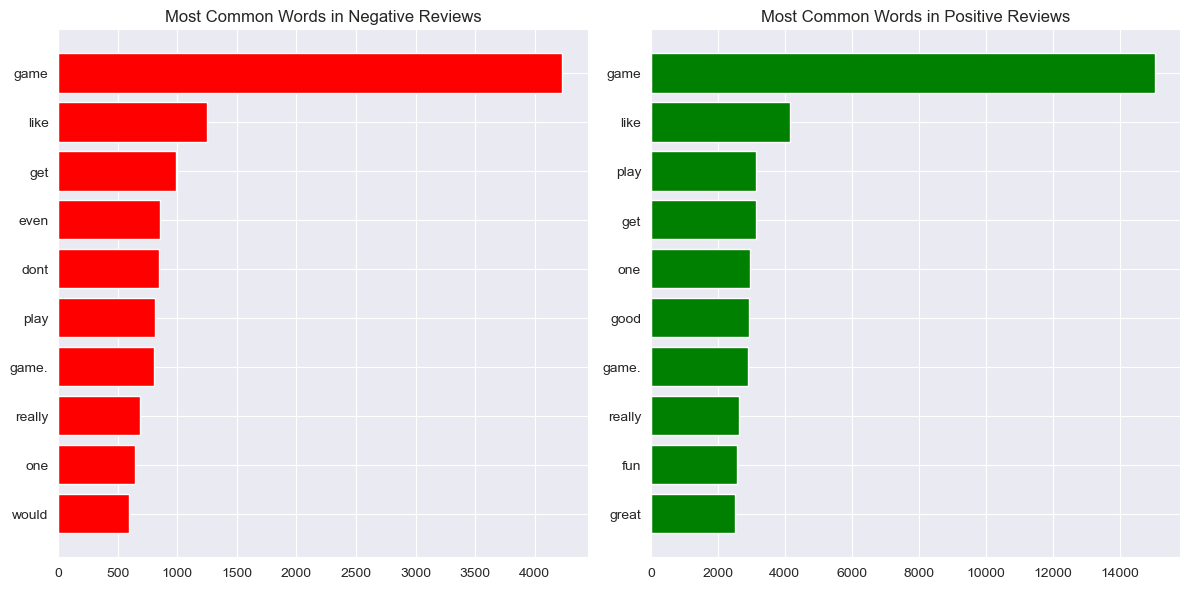

In [54]:
from collections import Counter
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
import nltk
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Tokenize the text (basic whitespace-based tokenization)
neg_words = " ".join(clean_df[clean_df['review_score'] == 0]['review_text']).split()
pos_words = " ".join(clean_df[clean_df['review_score'] == 1]['review_text']).split()

# Remove stopwords from the tokenized words
neg_words_filtered = [word for word in neg_words if word not in stop_words]
pos_words_filtered = [word for word in pos_words if word not in stop_words]

# Count frequency of filtered words
neg_word_counts = Counter(neg_words_filtered)
pos_word_counts = Counter(pos_words_filtered)

# Get the most common words
neg_common = neg_word_counts.most_common(10)
pos_common = pos_word_counts.most_common(10)

# Unzip the most common words and counts
neg_words, neg_counts = zip(*neg_common)
pos_words, pos_counts = zip(*pos_common)

# Plot bar charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].barh(neg_words, neg_counts, color='red')
axes[0].set_title('Most Common Words in Negative Reviews')
axes[0].invert_yaxis()  # Invert y-axis to have the highest bar on top

axes[1].barh(pos_words, pos_counts, color='green')
axes[1].set_title('Most Common Words in Positive Reviews')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

C:\Users\Parag\AppData\Local\Temp\ipykernel_2472\1916540677.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TF-IDF', y='Word', data=tfidf_df_neg, ax=axes[0], palette='Reds')
C:\Users\Parag\AppData\Local\Temp\ipykernel_2472\1916540677.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TF-IDF', y='Word', data=tfidf_df_pos, ax=axes[1], palette='Greens')


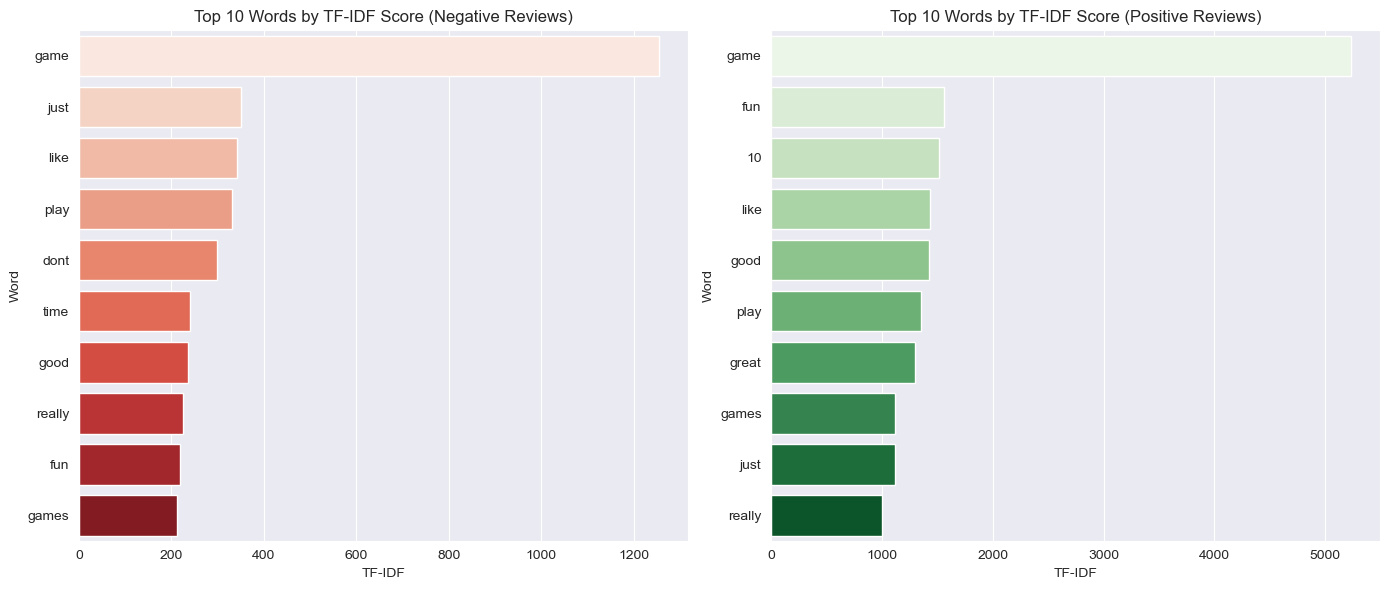

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Filter reviews for positive and negative sentiment
neg_reviews = clean_df[clean_df['review_score'] == 0]['review_text']
pos_reviews = clean_df[clean_df['review_score'] == 1]['review_text']

# Create TF-IDF Vectorizer and fit it on the negative reviews
vectorizer_neg = TfidfVectorizer(stop_words='english', max_features=10)
tfidf_matrix_neg = vectorizer_neg.fit_transform(neg_reviews)

# Get the top words by TF-IDF scores for negative reviews
feature_names_neg = vectorizer_neg.get_feature_names_out()
tfidf_scores_neg = tfidf_matrix_neg.sum(axis=0).A1

# Combine feature names and scores into a DataFrame for negative reviews
tfidf_df_neg = pd.DataFrame(list(zip(feature_names_neg, tfidf_scores_neg)), columns=['Word', 'TF-IDF'])
tfidf_df_neg = tfidf_df_neg.sort_values(by='TF-IDF', ascending=False)

# Create TF-IDF Vectorizer and fit it on the positive reviews
vectorizer_pos = TfidfVectorizer(stop_words='english', max_features=10)
tfidf_matrix_pos = vectorizer_pos.fit_transform(pos_reviews)

# Get the top words by TF-IDF scores for positive reviews
feature_names_pos = vectorizer_pos.get_feature_names_out()
tfidf_scores_pos = tfidf_matrix_pos.sum(axis=0).A1

# Combine feature names and scores into a DataFrame for positive reviews
tfidf_df_pos = pd.DataFrame(list(zip(feature_names_pos, tfidf_scores_pos)), columns=['Word', 'TF-IDF'])
tfidf_df_pos = tfidf_df_pos.sort_values(by='TF-IDF', ascending=False)

# Plot TF-IDF scores for negative and positive reviews side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x='TF-IDF', y='Word', data=tfidf_df_neg, ax=axes[0], palette='Reds')
axes[0].set_title('Top 10 Words by TF-IDF Score (Negative Reviews)')

sns.barplot(x='TF-IDF', y='Word', data=tfidf_df_pos, ax=axes[1], palette='Greens')
axes[1].set_title('Top 10 Words by TF-IDF Score (Positive Reviews)')

plt.tight_layout()
plt.show()


C:\Users\Parag\AppData\Local\Temp\ipykernel_2472\956900213.py:42: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Parag\AppData\Local\Temp\ipykernel_2472\956900213.py:42: UserWarning: Glyph 9996 (\N{VICTORY HAND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Parag\AppData\Local\Temp\ipykernel_2472\956900213.py:42: UserWarning: Glyph 128078 (\N{THUMBS DOWN SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Parag\AppData\Local\Temp\ipykernel_2472\956900213.py:42: UserWarning: Glyph 10052 (\N{SNOWFLAKE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Parag\AppData\Local\Temp\ipykernel_2472\956900213.py:42: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Parag\AppData\Local\Temp\ipykernel_2472\956900213.py:42: UserWarning: Glyph 9995 (\N{RAISED HAND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Parag\AppData\Local\Temp\ipykernel_2472\9

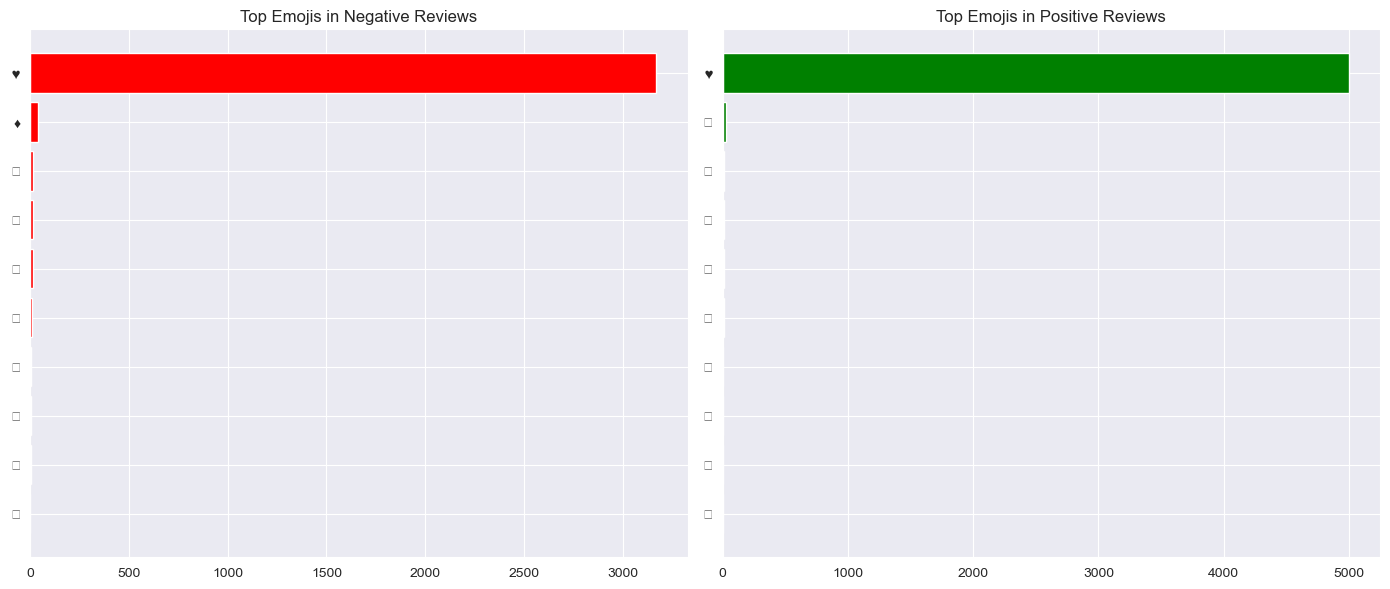

In [57]:
import emoji

# Function to extract emojis from a text
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

# Extract emojis from positive and negative reviews
neg_reviews = clean_df[clean_df['review_score'] == 0]['review_text']
pos_reviews = clean_df[clean_df['review_score'] == 1]['review_text']

# Extract emojis for negative reviews
neg_emojis = []
for review in neg_reviews:
    neg_emojis.extend(extract_emojis(review))

# Extract emojis for positive reviews
pos_emojis = []
for review in pos_reviews:
    pos_emojis.extend(extract_emojis(review))

# Count the occurrences of each emoji in negative and positive reviews
neg_emoji_counts = Counter(neg_emojis)
pos_emoji_counts = Counter(pos_emojis)

# Convert emoji counts to dataframes
neg_emoji_df = pd.DataFrame(neg_emoji_counts.items(), columns=['Emoji', 'Count']).sort_values(by='Count', ascending=False).head(10)
pos_emoji_df = pd.DataFrame(pos_emoji_counts.items(), columns=['Emoji', 'Count']).sort_values(by='Count', ascending=False).head(10)

# Plot emoji usage in both negative and positive reviews side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for negative reviews
axes[0].barh(neg_emoji_df['Emoji'], neg_emoji_df['Count'], color='red')
axes[0].set_title('Top Emojis in Negative Reviews')
axes[0].invert_yaxis()  # Invert y-axis for better readability

# Plot for positive reviews
axes[1].barh(pos_emoji_df['Emoji'], pos_emoji_df['Count'], color='green')
axes[1].set_title('Top Emojis in Positive Reviews')
axes[1].invert_yaxis()  # Invert y-axis for better readability

plt.tight_layout()
plt.show()


In [61]:
love_emoji = neg_emojis[0]
print(love_emoji)
clean_df[(clean_df['review_score'] == 0) & (clean_df['review_text'].str.contains(love_emoji))]

♥


,app_id,app_name,review_text,review_score,urls,contains_url,raw_text,review_length,word_counts
61,4000,Garry's Mod,this ♥♥♥♥ suk.,0,[],False,this ♥♥♥♥ suk.,14,3
202,273350,Evolve Stage 2,cant even fix a simple bug with mouse. ♥♥♥♥ing...,0,[],False,cant even fix a simple bug with mouse. ♥♥♥♥ing...,55,10
214,570,Dota 2,what the ♥♥♥♥ is this ♥♥♥♥.,0,[],False,What the ♥♥♥♥ is this ♥♥♥♥.,27,6
252,42990,Sword of the Stars II: Enhanced Edition,buggy pile of ♥♥♥♥. dont buy this.,0,[],False,Buggy pile of ♥♥♥♥. Don't buy this.,34,7
309,334120,Armikrog,being a fan of the original neverhood (skullmo...,0,[],False,Being a fan of the original Neverhood (Skullmo...,1256,229
...,...,...,...,...,...,...,...,...,...
16200,385710,INK,"this game is good as in levels, but here are t...",0,[],False,"This game is good as in levels, but here are t...",321,61
16222,289650,Assassin's Creed Unity,i was one of the main defenderes of this game....,0,[],False,I was one of the main defenderes of this game....,443,89
16397,334070,Hektor,oh my god i hate this game so much. at first i...,0,[],False,Oh my god I hate this game so much. At first ...,867,164
16432,55110,Red Faction: Armageddon,hey ♥♥♥♥ red faction gorilla lets just make a ...,0,[],False,HEY ♥♥♥♥ RED FACTION GORILLA LETS JUST MAKE A ...,91,17


In [63]:
clean_df

,app_id,app_name,review_text,review_score,urls,contains_url,raw_text,review_length,word_counts
0,252490,Rust,early access review,1,[],False,Early Access Review,19,3
1,107410,Arma 3,why wont this download,1,[],False,? why won't this download,22,4
2,459010,Ghost Town Mine Ride & Shootin' Gallery,really fantastic game experience a combination...,1,[],False,Really fantastic game experience - a combinati...,390,70
3,8930,Sid Meier's Civilization V,"go out on an adventure, be honerouble, get res...",1,[],False,"Go out on an adventure, be honerouble, get res...",1377,256
4,108710,Alan Wake,the best written game i have ever played as we...,1,[],False,The best written game I have ever played as we...,537,103
...,...,...,...,...,...,...,...,...,...
16484,255710,Cities: Skylines,some times this game will ♥♥♥♥ you over realy ...,1,[],False,some times this game will ♥♥♥♥ YOU OVER REALY ...,188,41
16485,250110,Assault Android Cactus,really solid twin stick shooter with tight con...,1,[],False,Really solid twin stick shooter with tight con...,849,149
16486,205950,Jet Set Radio,super brother,1,[],False,Super brother,13,2
16487,377160,Fallout 4,friggin awesome but not quite as good as fnv yet.,1,[],False,Friggin awesome but not quite as good as FNV.....,49,10
